In [22]:
reaction1 = 'C1CCCCC1.OO>>C1CCCCC1O'
reaction2 = 'C1CCCCC1.OO>>C1CCCCC1OO'

In [23]:
from rdkit import Chem
def assign_atom_mapping(smiles_reaction):
    try:
        reactants, products = smiles_reaction.split('>>')
        reactant_smiles = reactants.split('.')
        reactant_mols = [Chem.MolFromSmiles(r) for r in reactant_smiles]
        
        atom_map_num = 1  # Start numbering from 1 and increment globally
        for mol in reactant_mols:
            if mol:
                for atom in mol.GetAtoms():
                    atom.SetAtomMapNum(atom_map_num)
                    atom_map_num += 1  # Increment for each atom globally
        
        mapped_reactants = '.'.join([Chem.MolToSmiles(mol, canonical=False) for mol in reactant_mols if mol])
        mapped_reaction = f"{mapped_reactants}>>{products}"
        
        return mapped_reaction
    except Exception as e:
        return f"Error processing reaction: {e}"

In [24]:
def canonicalize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            raise ValueError("Invalid SMILES input.")
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception as e:
        return f"Error: {e}"
    
def canonicalize_reaction(smiles_reaction):
    try:
        reactants, products = smiles_reaction.split('>>')
        canonical_reactants = '.'.join(sorted([canonicalize_smiles(r) for r in reactants.split('.')]))
        canonical_products = '.'.join(sorted([canonicalize_smiles(p) for p in products.split('.')]))
        return f"{canonical_reactants}>>{canonical_products}"
    except Exception as e:
        return f"Error: {e}"

In [25]:
from rxnmapper import RXNMapper
print(reaction1, reaction2)
rxn_mapper = RXNMapper()
results = rxn_mapper.get_attention_guided_atom_maps([canonicalize_reaction(reaction1), canonicalize_reaction(reaction2)])
[i['mapped_rxn'] for i in results]

AlbertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the eager attention implementation, but specifying the eager implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
AlbertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the eager attention implementation, but specifying the eager implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
AlbertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embeddi

C1CCCCC1.OO>>C1CCCCC1O C1CCCCC1.OO>>C1CCCCC1OO


['[CH2:2]1[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7]1.O[OH:1]>>[OH:1][CH:2]1[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7]1',
 '[CH2:3]1[CH2:4][CH2:5][CH2:6][CH2:7][CH2:8]1.[OH:1][OH:2]>>[OH:1][O:2][CH:3]1[CH2:4][CH2:5][CH2:6][CH2:7][CH2:8]1']

In [26]:
assign_atom_mapping(canonicalize_reaction(reaction1))

'[CH2:1]1[CH2:2][CH2:3][CH2:4][CH2:5][CH2:6]1.[OH:7][OH:8]>>OC1CCCCC1'

In [27]:
import numpy as np
def map_atom_mappings(nativesmiles, smiles2):
    try:
        print(canonicalize_smiles(smiles2.split('>>')[0]))
        mol2 = Chem.MolFromSmiles()
        
        if not mol2:
            raise ValueError("Invalid SMILES input.")
        
        mapping_dict = {}

        
        atoms2 = [atom.GetAtomMapNum() for atom in mol2.GetAtoms() if atom.GetAtomMapNum()]
        atoms1 = np.arange(1, mol2.GetNumAtoms()+1)
        print(atoms1, atoms2)

        for idx, i in enumerate(atoms1):
            print(i, atoms2[idx])
            mapping_dict[i] = atoms2[idx]
        
        return mapping_dict
    except Exception as e:
        return {"error": str(e)}

In [28]:
map_atom_mappings('[CH3:1][CH2:2][OH:3].[CH:4](=[O:5])[Cl:6]', '[CH3:1][CH2:2][OH:3].Cl[CH:4]=[O:6]>>[CH3:1][CH2:2][O:3][C:4]([CH3:5])=[O:6]')

Cl[CH:4]=[O:6].[CH3:1][CH2:2][OH:3]


{'error': 'Python argument types in\n    rdkit.Chem.rdmolfiles.MolFromSmiles()\ndid not match C++ signature:\n    MolFromSmiles(boost::python::api::object SMILES, bool sanitize=True, boost::python::dict replacements={})\n    MolFromSmiles(boost::python::api::object SMILES, RDKit::v1::SmilesParserParams params)'}

In [29]:
def complete_atom_mapping(smiles):
    reactants, products = smiles.split(">>")
    
    molecules = reactants.split('.') + products.split('.')
    
    highest_map = 0
    for mol in molecules:
        parsed_mol = Chem.MolFromSmiles(mol)
        if parsed_mol is not None:
            for atom in parsed_mol.GetAtoms():
                map_num = atom.GetAtomMapNum()
                if map_num > highest_map:
                    highest_map = map_num
    
    new_map_num = highest_map + 1
    updated_molecules = []
    for mol in molecules:
        parsed_mol = Chem.MolFromSmiles(mol)
        if parsed_mol is not None:
            for atom in parsed_mol.GetAtoms():
                if atom.GetAtomMapNum() == 0:
                    atom.SetAtomMapNum(new_map_num)
                    new_map_num += 1
            updated_molecules.append(Chem.MolToSmiles(parsed_mol))
    
    updated_reactants = '.'.join(updated_molecules[:len(reactants.split('.'))])
    updated_products = '.'.join(updated_molecules[len(reactants.split('.')):])
    return f"{updated_reactants}>>{updated_products}"

In [33]:
from preprocess import consistent_mapping
reaction1 = complete_atom_mapping('[CH2:2]1[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7]1.O[OH:1]>>[OH:1][CH:2]1[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7]1')
reaction2 =  '[CH2:3]1[CH2:4][CH2:5][CH2:6][CH2:7][CH2:8]1.[OH:1][OH:2]>>[OH:1][O:2][CH:3]1[CH2:4][CH2:5][CH2:6][CH2:7][CH2:8]1'
reaction3 = '[CH2:26]1[CH2:27][CH2:28][O:29][CH2:30]1.[CH3:31][CH2:32][CH2:33][CH2:34][CH2:35][CH2:36][CH3:37].[OH:12][CH2:13][CH2:14][CH:15]1[CH2:16][CH2:17][N:18]([CH3:19])[CH2:20][CH2:21]1.[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:45][c:44]3[cH:43][cH:42][c:41]([N+:39](=[O:38])[O-:40])[cH:47][cH:46]3)[CH2:22][CH2:23]2)[cH:24][cH:25]1.[H-:48].[Na+:49]>>[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:12][CH2:13][CH2:14][CH:15]3[CH2:16][CH2:17][N:18]([CH3:19])[CH2:20][CH2:21]3)[CH2:22][CH2:23]2)[cH:24][cH:25]1'
reaction4 = '[CH2:25]1[CH2:26][CH2:27][O:28][CH2:29]1.[CH3:30][CH2:31][CH2:32][CH2:33][CH2:34][CH2:35][CH3:36].[OH:12][CH2:13][CH2:14][CH:15]1[CH2:16][CH2:17][N:18]([CH3:37])[CH2:19][CH2:20]1.[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:45][c:44]3[cH:43][cH:42][c:41]([N+:39](=[O:38])[O-:40])[cH:47][cH:46]3)[CH2:21][CH2:22]2)[cH:23][cH:24]1.[H-:48].[Na+:49]>>[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:12][CH2:13][CH2:14][CH:15]3[CH2:16][CH2:17][NH:18][CH2:19][CH2:20]3)[CH2:21][CH2:22]2)[cH:23][cH:24]1'
consistent_mapping([reaction3, reaction4])

({1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25}, 25)
({1: 50, 2: 51, 3: 52, 4: 53, 5: 54, 6: 55, 7: 56, 8: 57, 9: 58, 10: 59, 11: 60, 12: 61, 13: 62, 14: 63, 15: 64, 16: 65, 17: 66, 18: 67, 19: 68, 20: 69, 21: 70, 22: 71, 23: 72, 24: 73}, 73)


('[CH2:45]1[CH2:46][CH2:47][O:48][CH2:49]1.[CH3:18][c:19]1[cH:20][cH:21][c:22]([N:23]2[CH2:24][CH2:25][N:26]([C:27](=[O:28])[O:29][c:30]3[cH:31][cH:32][c:33]([N+:34](=[O:35])[O-:36])[cH:37][cH:38]3)[CH2:39][CH2:40]2)[cH:41][cH:42]1.[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH3:7].[H-:43].[Na+:44].[OH:8][CH2:9][CH2:10][CH:11]1[CH2:12][CH2:13][N:14]([CH3:15])[CH2:16][CH2:17]1',
 ['[O:8]([CH2:9][CH2:10][CH:11]1[CH2:12][CH2:13][N:14]([CH3:15])[CH2:16][CH2:17]1)[C:27]([N:26]1[CH2:25][CH2:24][N:23]([c:22]2[cH:21][cH:20][c:19]([CH3:18])[cH:42][cH:41]2)[CH2:40][CH2:39]1)=[O:28]',
  '[O:8]([CH2:9][CH2:10][CH:11]1[CH2:12][CH2:13][NH:14][CH2:16][CH2:17]1)[C:27]([N:26]1[CH2:25][CH2:24][N:23]([c:22]2[cH:21][cH:20][c:19]([CH3:18])[cH:42][cH:41]2)[CH2:40][CH2:39]1)=[O:28]'],
 '[CH2:45]1[CH2:46][CH2:47][O:48][CH2:49]1.[CH3:18][c:19]1[cH:20][cH:21][c:22]([N:23]2[CH2:24][CH2:25][N:26]([C:27](=[O:28])[O:29][c:30]3[cH:31][cH:32][c:33]([N+:34](=[O:35])[O-:36])[cH:37][cH:38]3)[CH2:39][CH2:40]2)[cH:41][cH:4

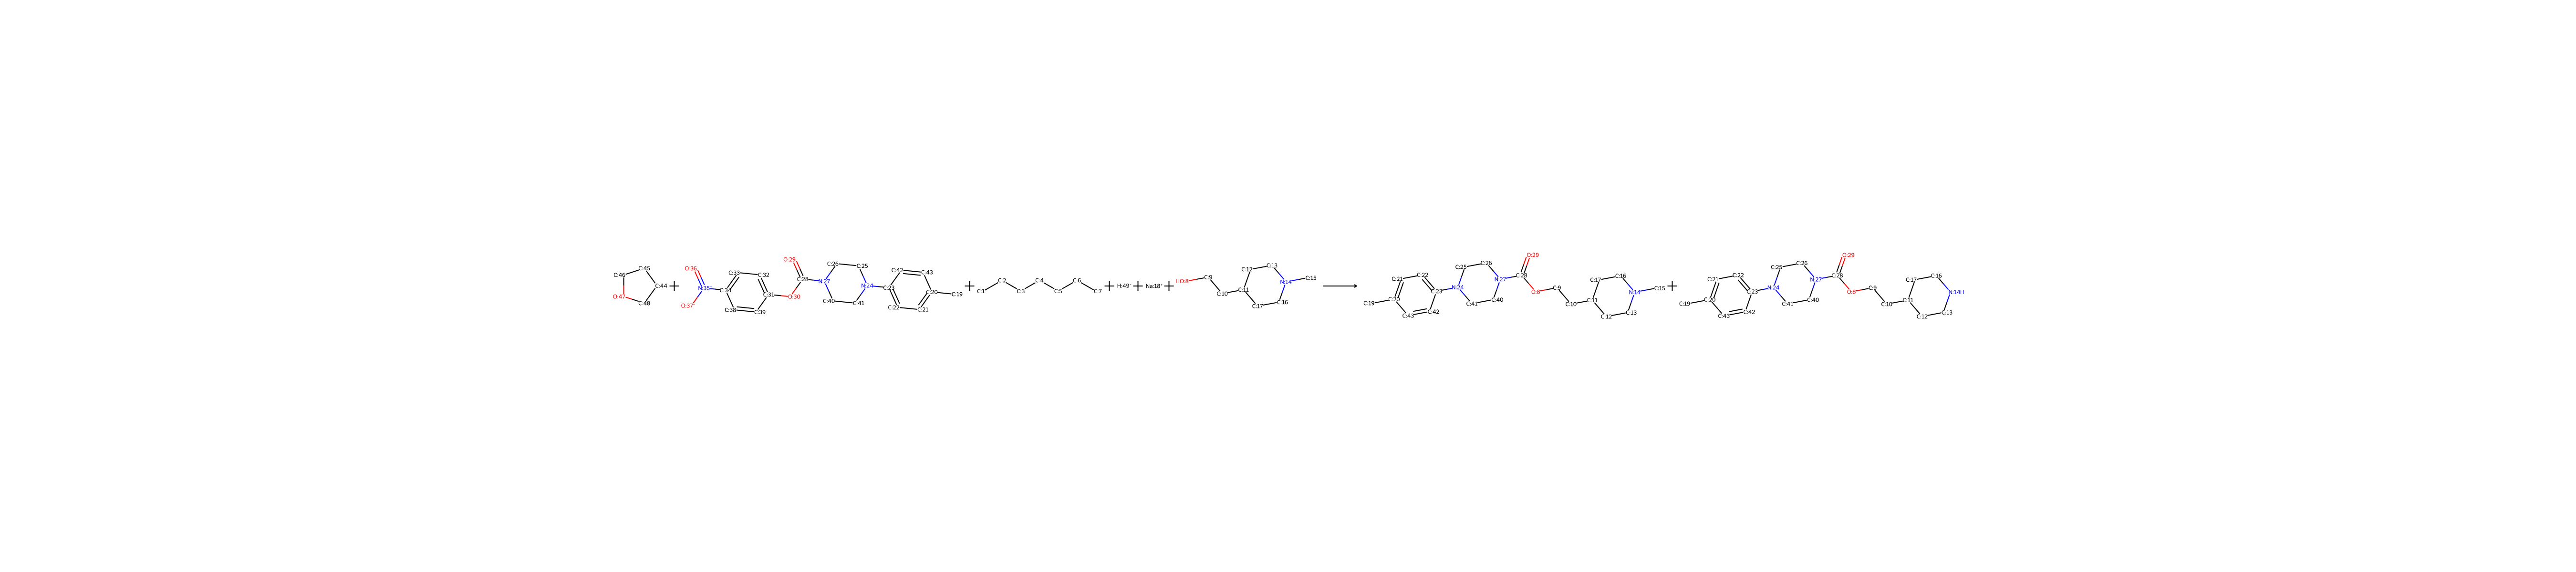

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
reaction = rdChemReactions.ReactionFromSmarts('[CH2:44]1[CH2:45][CH2:46][O:47][CH2:48]1.[CH3:19][c:20]1[cH:21][cH:22][c:23]([N:24]2[CH2:25][CH2:26][N:27]([C:28](=[O:29])[O:30][c:31]3[cH:32][cH:33][c:34]([N+:35](=[O:36])[O-:37])[cH:38][cH:39]3)[CH2:40][CH2:41]2)[cH:42][cH:43]1.[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH3:7].[H-:49].[Na+:18].[OH:8][CH2:9][CH2:10][CH:11]1[CH2:12][CH2:13][N:14]([CH3:15])[CH2:16][CH2:17]1>>[O:8]([CH2:9][CH2:10][CH:11]1[CH2:12][CH2:13][N:14]([CH3:15])[CH2:16][CH2:17]1)[C:28]([N:27]1[CH2:26][CH2:25][N:24]([c:23]2[cH:22][cH:21][c:20]([CH3:19])[cH:43][cH:42]2)[CH2:41][CH2:40]1)=[O:29].[O:8]([CH2:9][CH2:10][CH:11]1[CH2:12][CH2:13][NH:14][CH2:16][CH2:17]1)[C:28]([N:27]1[CH2:26][CH2:25][N:24]([c:23]2[cH:22][cH:21][c:20]([CH3:19])[cH:43][cH:42]2)[CH2:41][CH2:40]1)=[O:29]', useSmiles=True)
display(Draw.ReactionToImage(reaction, subImgSize=(600, 1200)))

In [1]:
from utils import unmap_smiles

unmap_smiles('[CH2:25]1[CH2:26][CH2:27][O:28][CH2:29]1.[CH3:30][CH2:31][CH2:32][CH2:33][CH2:34][CH2:35][CH3:36].[OH:12][CH2:13][CH2:14][CH:15]1[CH2:16][CH2:17][N:18]([CH3:37])[CH2:19][CH2:20]1.[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:45][c:44]3[cH:43][cH:42][c:41]([N+:39](=[O:38])[O-:40])[cH:47][cH:46]3)[CH2:21][CH2:22]2)[cH:23][cH:24]1.[H-:48].[Na+:49]>>[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:12][CH2:13][CH2:14][CH:15]3[CH2:16][CH2:17][NH:18][CH2:19][CH2:20]3)[CH2:21][CH2:22]2)[cH:23][cH:24]1')

[14:23:45] WARNING: not removing hydrogen atom without neighbors


'C1CCOC1.CCCCCCC.CN1CCC(CCO)CC1.Cc1ccc(N2CCN(C(=O)Oc3ccc([N+](=O)[O-])cc3)CC2)cc1.[H-].[Na+]>Cc1ccc(N2CCN(C(=O)OCCC3CCNCC3)CC2)cc1'

In [ ]:
from utils import get_multi
from preprocess import consistent_mapping




1.0

0.5

1.0

0.5

1.0

0.5

0.3333333333333333

1.0

0.5

0.3333333333333333

[['[CH2:26]1[CH2:27][CH2:28][O:29][CH2:30]1.[CH3:31][CH2:32][CH2:33][CH2:34][CH2:35][CH2:36][CH3:37].[OH:12][CH2:13][CH2:14][CH:15]1[CH2:16][CH2:17][N:18]([CH3:19])[CH2:20][CH2:21]1.[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:45][c:44]3[cH:43][cH:42][c:41]([N+:39](=[O:38])[O-:40])[cH:47][cH:46]3)[CH2:22][CH2:23]2)[cH:24][cH:25]1.[H-:48].[Na+:49]>>[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:12][CH2:13][CH2:14][CH:15]3[CH2:16][CH2:17][N:18]([CH3:19])[CH2:20][CH2:21]3)[CH2:22][CH2:23]2)[cH:24][cH:25]1 10-12-1.0;10-45-0.0 1.0', '[CH2:25]1[CH2:26][CH2:27][O:28][CH2:29]1.[CH3:30][CH2:31][CH2:32][CH2:33][CH2:34][CH2:35][CH3:36].[OH:12][CH2:13][CH2:14][CH:15]1[CH2:16][CH2:17][N:18]([CH3:37])[CH2:19][CH2:20]1.[CH3:1][c:2]1[cH:3][cH:4][c:5]([N:6]2[CH2:7][CH2:8][N:9]([C:10](=[O:11])[O:45][c:44]3[cH:43][cH:42][c:41]([N+:39](=[O:38])[O-:40])[cH:47][cH:46]3)[C

[CH2:12]1[CH2:13][CH2:14][O:15][CH2:16]1.[CH3:18][CH2:19][CH2:20][CH2:21][CH2:22][CH2:23][CH3:24].[CH3:25][c:26]1[cH:27][cH:28][c:29]([N:30]2[CH2:31][CH2:32][N:33]([C:34](=[O:35])[O:36][c:37]3[cH:38][cH:39][c:40]([N+:41](=[O:42])[O-:43])[cH:44][cH:45]3)[CH2:46][CH2:47]2)[cH:48][cH:49]1.[H-:17].[Na+:1].[OH:2][CH2:3][CH2:4][CH:5]1[CH2:6][CH2:7][N:8]([CH3:9])[CH2:10][CH2:11]1>>[O:2]([CH2:3][CH2:4][CH:5]1[CH2:6][CH2:7][NH:8][CH2:10][CH2:11]1)[C:34]([N:33]1[CH2:32][CH2:31][N:30]([c:29]2[cH:28][cH:27][c:26]([CH3:25])[cH:49][cH:48]2)[CH2:47][CH2:46]1)=[O:35].[O:2]([CH2:3][CH2:4][CH:5]1[CH2:6][CH2:7][N:8]([CH3:9])[CH2:10][CH2:11]1)[C:34]([N:33]1[CH2:32][CH2:31][N:30]([c:29]2[cH:28][cH:27][c:26]([CH3:25])[cH:49][cH:48]2)[CH2:47][CH2:46]1)=[O:35]
[O:1]=[C:2]([O:3][CH2:4][CH:5]1[CH2:6][CH2:7][N:8]([C:9]([O:10][C:11]([CH3:12])([CH3:13])[CH3:14])=[O:15])[CH2:16][CH2:17]1)[CH:18]1[CH2:19][CH2:20][CH:21]2[CH2:22][N:23]1[C:24](=[O:25])[N:26]2[O:27][S:28](=[O:29])(=[O:30])[OH:31].[O:32]=[C:33]([OH:34])[C:35]([F:36])([F:37])[F:38]>>[O:1]=[C:2]([O:3][CH2:4][CH:5]1[CH2:6][CH2:7][NH:8][CH2:16][CH2:17]1)[CH:18]1[CH2:19][CH2:20][CH:21]2[CH2:22][N:23]1[C:24](=[O:25])[N:26]2[O:27][S:28](=[O:29])(=[O:30])[OH:31].[O:1]=[C:2]([O:3][CH2:4][CH:5]1[CH2:6][CH2:7][NH:8][CH2:16][CH2:17]1)[CH:18]1[CH2:19][CH2:20][CH:21]2[CH2:22][N:23]1[C:24](=[O:25])[N:26]2[O:27][SH:28](=[O:29])([OH:30])[OH:31]
[C:26](=[O:27])([c:28]1[cH:29][cH:30][cH:31][cH:32][cH:33]1)[Cl:34].[CH3:4][CH2:5][C:6]12[CH2:7][CH2:8][CH:9]3[CH:10]4[CH2:11][CH2:12][C:13](=[O:14])[CH:15]=[C:16]4[CH2:17][CH2:18][CH:19]3[CH:20]1[CH:21]([OH:22])[CH2:23][C:24]2=[O:25].[Cl:1][CH2:2][Cl:3].[OH2:35].[cH:36]1[cH:37][cH:38][n:39][cH:40][cH:41]1>>[CH3:4][CH2:5][C:6]12[CH2:7][CH2:8][CH:9]3[CH:10]4[CH2:11][CH2:12][C:13](=[O:14])[CH:15]=[C:16]4[CH2:17][CH2:18][CH:19]3[CH:20]1[CH:21]([O:22][C:26](=[O:27])[c:28]1[cH:29][cH:30][cH:31][cH:32][cH:33]1)[CH2:23][C:24]2=[O:25].[CH3:4][CH2:5][C:6]12[CH2:7][CH2:8][CH:9]3[CH:10]4[CH2:11][CH2:12][C:13](=[O:14])[CH:15]=[C:16]4[CH2:17][CH2:18][CH:19]3[CH:20]1[CH:21]=[CH:23][C:24]2=[O:25].[CH3:4][CH2:5][C:6]12[CH2:7][CH2:8][CH:9]3[CH:10]4[CH2:11][CH2:12][C:13](=[O:14])[CH:15]=[C:16]4[CH2:17][CH2:18][CH:19]3[CH:20]1[CH:21]([O:22][CH2:26][c:28]1[cH:29][cH:30][cH:31][cH:32][cH:33]1)[CH2:23][C:24]2=[O:25]
[CH3:2][CH2:3][N:4]([CH2:5][CH3:6])[CH2:7][CH2:8][N:9]([CH3:10])[CH2:11][c:12]1[cH:13][c:14]([CH3:15])[cH:16][c:17]([C:18](=[O:19])[O:20][CH3:21])[cH:22]1.[Na+:23].[OH-:1]>>[CH3:2][CH2:3][N:4]([CH2:5][CH3:6])[CH2:7][CH2:8][N:9]([CH3:10])[CH2:11][c:12]1[cH:13][c:14]([CH3:15])[cH:16][c:17]([C:18](=[O:19])[OH:20])[cH:22]1.[cH:12]1[cH:13][cH:14][cH:16][c:17]([C:18](=[O:19])[OH:20])[cH:22]1.[CH3:2][CH2:3][N:4]([CH2:5][CH3:6])[CH2:7][CH2:8][NH:9][CH2:11][c:12]1[cH:13][c:14]([CH3:15])[cH:16][c:17]([C:18](=[O:19])[OH:20])[cH:22]1


[CH2:35]1[CH2:36][CH2:37][O:38][CH2:39]1.[CH3:10][c:11]1[cH:12][cH:13][c:14]([N:15]2[CH2:16][CH2:17][N:18]([C:19](=[O:20])[O:21][c:22]3[cH:23][cH:24][c:25]([N+:26](=[O:27])[O-:28])[cH:29][cH:30]3)[CH2:31][CH2:32]2)[cH:33][cH:34]1.[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH3:7].[H-:9].[Na+:8].[OH:40][CH2:41][CH2:42][CH:43]1[CH2:44][CH2:45][N:46]([CH3:47])[CH2:48][CH2:49]1>>[CH3:10][c:11]1[cH:12][cH:13][c:14]([N:15]2[CH2:16][CH2:17][N:18]([C:19](=[O:20])[O:40][CH2:41][CH2:42][CH:43]3[CH2:44][CH2:45][N:46]([CH3:47])[CH2:48][CH2:49]3)[CH2:31][CH2:32]2)[cH:33][cH:34]1.[CH3:10][c:11]1[cH:12][cH:13][c:14]([N:15]2[CH2:16][CH2:17][N:18]([C:19](=[O:20])[O:40][CH2:41][CH2:42][CH:43]3[CH2:44][CH2:45][NH:46][CH2:48][CH2:49]3)[CH2:31][CH2:32]2)[cH:33][cH:34]1
[O:1]=[C:2]([O:3][CH2:4][CH:5]1[CH2:6][CH2:7][N:8]([C:9]([O:10][C:11]([CH3:12])([CH3:13])[CH3:14])=[O:15])[CH2:16][CH2:17]1)[CH:18]1[CH2:19][CH2:20][CH:21]2[CH2:22][N:23]1[C:24](=[O:25])[N:26]2[O:27][S:28](=[O:29])(=[O:30])[OH:31].[O:32]=[C:33]([OH:34])[C:35]([F:36])([F:37])[F:38]>>[O:1]=[C:2]([O:3][CH2:4][CH:5]1[CH2:6][CH2:7][NH:8][CH2:16][CH2:17]1)[CH:18]1[CH2:19][CH2:20][CH:21]2[CH2:22][N:23]1[C:24](=[O:25])[N:26]2[O:27][S:28](=[O:29])(=[O:30])[OH:31].[O:1]=[C:2]([O:3][CH2:4][CH:5]1[CH2:6][CH2:7][NH:8][CH2:16][CH2:17]1)[CH:18]1[CH2:19][CH2:20][CH:21]2[CH2:22][N:23]1[C:24](=[O:25])[N:26]2[O:27][SH:28](=[O:29])([OH:30])[OH:31]
[C:26](=[O:27])([c:28]1[cH:29][cH:30][cH:31][cH:32][cH:33]1)[Cl:34].[CH3:4][CH2:5][C:6]12[CH2:7][CH2:8][CH:9]3[CH:10]4[CH2:11][CH2:12][C:13](=[O:14])[CH:15]=[C:16]4[CH2:17][CH2:18][CH:19]3[CH:20]1[CH:21]([OH:22])[CH2:23][C:24]2=[O:25].[Cl:1][CH2:2][Cl:3].[OH2:35].[cH:36]1[cH:37][cH:38][n:39][cH:40][cH:41]1>>[CH3:4][CH2:5][C:6]12[CH2:7][CH2:8][CH:9]3[CH:10]4[CH2:11][CH2:12][C:13](=[O:14])[CH:15]=[C:16]4[CH2:17][CH2:18][CH:19]3[CH:20]1[CH:21]([O:22][C:26](=[O:27])[c:28]1[cH:29][cH:30][cH:31][cH:32][cH:33]1)[CH2:23][C:24]2=[O:25].[CH3:4][CH2:5][C:6]12[CH2:7][CH2:8][CH:9]3[CH:10]4[CH2:11][CH2:12][C:13](=[O:14])[CH:15]=[C:16]4[CH2:17][CH2:18][CH:19]3[CH:20]1[CH:21]=[CH:23][C:24]2=[O:25].[CH3:4][CH2:5][C:6]12[CH2:7][CH2:8][CH:9]3[CH:10]4[CH2:11][CH2:12][C:13](=[O:14])[CH:15]=[C:16]4[CH2:17][CH2:18][CH:19]3[CH:20]1[CH:21]([O:22][CH2:26][c:28]1[cH:29][cH:30][cH:31][cH:32][cH:33]1)[CH2:23][C:24]2=[O:25]
[CH3:2][CH2:3][N:4]([CH2:5][CH3:6])[CH2:7][CH2:8][N:9]([CH3:10])[CH2:11][c:12]1[cH:13][c:14]([CH3:15])[cH:16][c:17]([C:18](=[O:19])[O:20][CH3:21])[cH:22]1.[Na+:23].[OH-:1]>>[CH3:2][CH2:3][N:4]([CH2:5][CH3:6])[CH2:7][CH2:8][N:9]([CH3:10])[CH2:11][c:12]1[cH:13][c:14]([CH3:15])[cH:16][c:17]([C:18](=[O:19])[OH:20])[cH:22]1.[cH:12]1[cH:13][cH:14][cH:16][c:17]([C:18](=[O:19])[OH:20])[cH:22]1.[CH3:2][CH2:3][N:4]([CH2:5][CH3:6])[CH2:7][CH2:8][NH:9][CH2:11][c:12]1[cH:13][c:14]([CH3:15])[cH:16][c:17]([C:18](=[O:19])[OH:20])[cH:22]1
